# 1. Imports and Configuration
Here we import the necessary libraries (TensorFlow, NumPy, Matplotlib) and set our hyperparameters.
* **Batch Size:** 128 images per training step.
* **Latent Dim:** 2 (We compress images into a 2D plane so we can visualize them easily).
* **Epochs:** 15 (Sufficient for MNIST to converge).

In [1]:
# --- 1. Imports & Configuration ---
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

In [2]:
# Clear any previous sessions
keras.backend.clear_session()

# Configuration
IMG_SHAPE = (28, 28, 1)
BATCH_SIZE = 128
LATENT_DIM = 2  # 2D latent space for easy visualization
EPOCHS = 15

print(f"TensorFlow Version: {tf.__version__}")

TensorFlow Version: 2.19.0


# 2. Data Preparation
We load the MNIST dataset using Keras.
* **Normalization:** We divide pixel values by 255.0 to scale them between 0 and 1. This is crucial because our decoder uses a `sigmoid` activation function (which outputs 0-1).
* **Reshaping:** We add a channel dimension to make the images (28, 28, 1) compatible with Conv2D layers.

In [3]:
# Load Data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
# Normalize (0 to 1) and Reshape
x_train = x_train.astype("float32") / 255.0
x_train = np.reshape(x_train, (-1, 28, 28, 1))

x_test = x_test.astype("float32") / 255.0
x_test = np.reshape(x_test, (-1, 28, 28, 1))

print(f"Training data shape: {x_train.shape}")

Training data shape: (60000, 28, 28, 1)


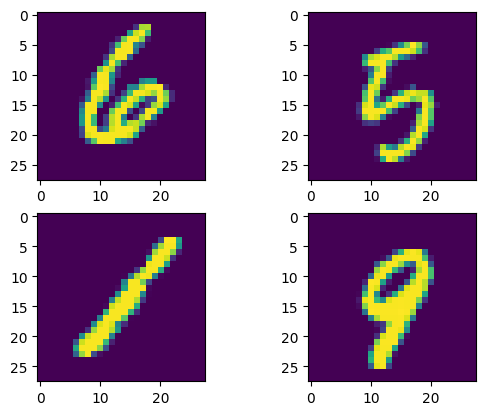

In [5]:
plt.figure(1)
plt.subplot(221)
plt.imshow(x_train[13][:,:,0])

plt.subplot(222)
plt.imshow(x_train[690][:,:,0])

plt.subplot(223)
plt.imshow(x_train[2375][:,:,0])

plt.subplot(224)
plt.imshow(x_train[42013][:,:,0])
plt.show()

# 3. Build the Encoder
The **Encoder** compresses the input image into a latent space.
1.  **Sampling Layer:** Instead of outputting a fixed vector $z$, the encoder outputs a mean ($\mu$) and a log-variance ($\log \sigma^2$). We use the **Reparameterization Trick** ($z = \mu + \sigma \cdot \epsilon$) to allow backpropagation through random sampling.
2.  **Architecture:** We use two Convolutional layers with stride 2 to downsample the image, followed by a Dense layer.

In [6]:
# A. Sampling Layer (Reparameterization Trick)
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [7]:
# B. Encoder Network
encoder_inputs = keras.Input(shape=IMG_SHAPE)
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)

z_mean = layers.Dense(LATENT_DIM, name="z_mean")(x)
z_log_var = layers.Dense(LATENT_DIM, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 14, 14,    │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 7, 7, 64)  │     18,496 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 3136)      │          0 │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 16)        │     50,192 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │         34 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │         34 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 2)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 69,076 (269.83 KB)

 Trainable params: 69,076 (269.83 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# C. Decoder Network
latent_inputs = keras.Input(shape=(LATENT_DIM,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)

decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3136)           │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 28, 28, 1)      │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,089 (254.25 KB)

 Trainable params: 65,089 (254.25 KB)

 Non-trainable params: 0 (0.00 B)

# 4. Build the Decoder
The **Decoder** takes the point $z$ from the latent space and reconstructs the original image.
* **Architecture:** We mirror the encoder. We use `Conv2DTranspose` layers to upsample the image back to 28x28.
* **Output Activation:** We use `sigmoid` to ensure the final pixels are between 0 and 1.

In [9]:
# C. Decoder Network
latent_inputs = keras.Input(shape=(LATENT_DIM,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)

decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3136)           │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 14, 14, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 28, 28, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 28, 28, 1)      │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,089 (254.25 KB)

 Trainable params: 65,089 (254.25 KB)

 Non-trainable params: 0 (0.00 B)

# 5. Define VAE Model (Custom Training Loop)
We subclass `keras.Model` to create a VAE that handles its own loss calculation.
* **Reconstruction Loss:** Measures how well the decoded image matches the original (Binary Cross Entropy).
* **KL Divergence Loss:** Measures how far our latent distribution is from a standard normal distribution (Regularization).
* **Total Loss:** Reconstruction Loss + KL Loss.

In [10]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        # Track loss statistics
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            # Reconstruction Loss (Binary Cross Entropy)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )

            # KL Divergence Loss
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

# 6. Train the VAE
We compile the model with the Adam optimizer and fit it to the training data.

In [11]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

print("Starting training...")
vae.fit(x_train, epochs=EPOCHS, batch_size=BATCH_SIZE)

Starting training...
Epoch 1/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 90s 182ms/step - kl_loss: 3.3032 - loss: 257.5288 - reconstruction_loss: 254.2255
Epoch 2/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 84s 179ms/step - kl_loss: 3.2420 - loss: 189.7496 - reconstruction_loss: 186.5076
Epoch 3/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 85s 182ms/step - kl_loss: 5.1800 - loss: 173.1853 - reconstruction_loss: 168.0053
Epoch 4/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 85s 181ms/step - kl_loss: 6.0164 - loss: 163.1124 - reconstruction_loss: 157.0959
Epoch 5/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 142s 181ms/step - kl_loss: 6.1780 - loss: 160.0623 - reconstruction_loss: 153.8843
Epoch 6/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 86s 184ms/step - kl_loss: 6.2731 - loss: 158.2776 - reconstruction_loss: 152.0045
Epoch 7/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 84s 179ms/step - kl_loss: 6.2879 - loss: 157.2050 - reconstruction_loss: 150.9171
Epoch 8/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 145s 187ms/step - kl_loss: 6.3612 - loss: 156.0544 - reconstruction_loss: 149.6931
E

# 7. Visualization: Latent Space Clusters
We project the test dataset into the 2D latent space.
* Each point represents an image of a digit.
* The colors represent the actual digit class (0-9).
* This shows us how the VAE has "clustered" similar digits together in the compressed space.

Generating Latent Space Cluster Plot...
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


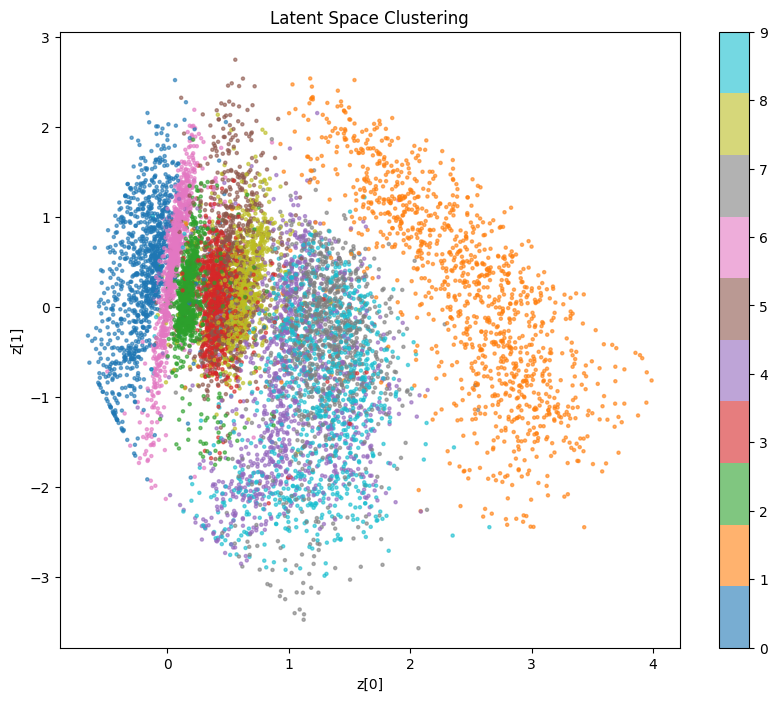

In [12]:
def plot_label_clusters(encoder, data, labels):
    # Display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(data)
    plt.figure(figsize=(10, 8))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels, cmap='tab10', alpha=0.6, s=5)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.title("Latent Space Clustering")
    plt.show()

print("Generating Latent Space Cluster Plot...")
plot_label_clusters(encoder, x_test, y_test)

# 8. Visualization: Generative Manifold
We sample points from a 2D grid (using the inverse CDF of the Gaussian distribution) and pass them through the **Decoder**.
* This generates completely **new** digits that do not exist in the dataset.
* It demonstrates the smooth transitions between different digits in the latent space.

Generating Manifold of Digits...


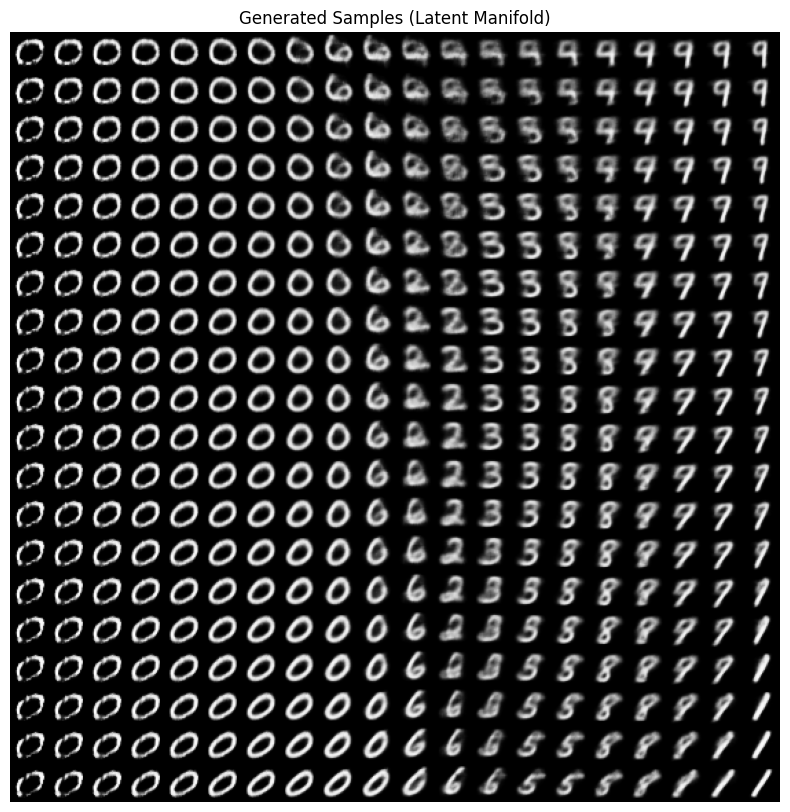

In [13]:
def plot_latent_space(decoder, n=20, digit_size=28):
    # Grid of values
    grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
    grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

    image_width = digit_size * n
    image_height = digit_size * n
    image = np.zeros((image_height, image_width))

    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample, verbose=0)
            digit = x_decoded[0].reshape(digit_size, digit_size)

            # Place the digit in the grid
            image[i * digit_size: (i + 1) * digit_size,
                  j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='Greys_r')
    plt.axis('off')
    plt.title("Generated Samples (Latent Manifold)")
    plt.show()

print("Generating Manifold of Digits...")
plot_latent_space(decoder)